In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import datetime, pytz
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


In [27]:
# Load NVIDIA stock data from Yahoo Finance
nvidia = yf.download('NVDA', start='2018-01-01', end='2024-01-01', interval='1d')
nvidia.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,48.945000,49.875000,48.625000,49.837502,49.310478,35561600
2018-01-03,51.025002,53.424999,50.937500,53.117500,52.555790,91470400
2018-01-04,53.939999,54.512501,53.172501,53.397499,52.832836,58326800
2018-01-05,53.547501,54.227501,52.770000,53.849998,53.280537,58012400
2018-01-08,55.099998,56.250000,54.645000,55.500000,54.913097,88121600


In [28]:
# Define technical indicator functions
def moving_average(df, window):
    return df['Close'].rolling(window=window).mean()

def exponential_moving_average(df, window):
    return df['Close'].ewm(span=window, adjust=False).mean()

def momentum(df, window):
    return df['Close'].diff(window)

def rsi(df, window):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# Calculate technical indicators
nvidia['SMA10'] = moving_average(nvidia, 10)
nvidia['SMA60'] = moving_average(nvidia, 60)
nvidia['EMA10'] = exponential_moving_average(nvidia, 10)
nvidia['Momentum'] = momentum(nvidia, 10)
nvidia['RSI'] = rsi(nvidia, 14)

# Drop NaN values
nvidia.dropna(inplace=True)
nvidia.head()


,Open,High,Low,Close,Adj Close,Volume,SMA10,SMA60,EMA10,Momentum,RSI
Date,,,,,,,,,,,
2018-03-28,56.032501,57.347500,54.250000,55.337502,54.786327,94590400,60.128250,58.758333,59.216354,-6.847500,38.012335
2018-03-29,56.027500,58.875000,55.174999,57.897499,57.320854,91662800,59.684500,58.892667,58.976562,-4.437500,42.263505
2018-04-02,57.185001,58.662498,54.375000,55.262501,54.712078,92209200,58.948750,58.928417,58.301278,-7.357498,34.875140
2018-04-03,56.950001,57.587502,55.337502,56.337502,55.776382,66743200,58.557500,58.977417,57.944228,-3.912498,38.493202
2018-04-04,53.752499,56.665001,53.500000,56.560001,55.996670,78916800,57.974001,59.022583,57.692550,-5.834999,38.404448


C:\Users\Me\AppData\Local\Temp\ipykernel_8712\2964378904.py:3: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\Me\AppData\Local\Temp\ipykernel_8712\2964378904.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a 

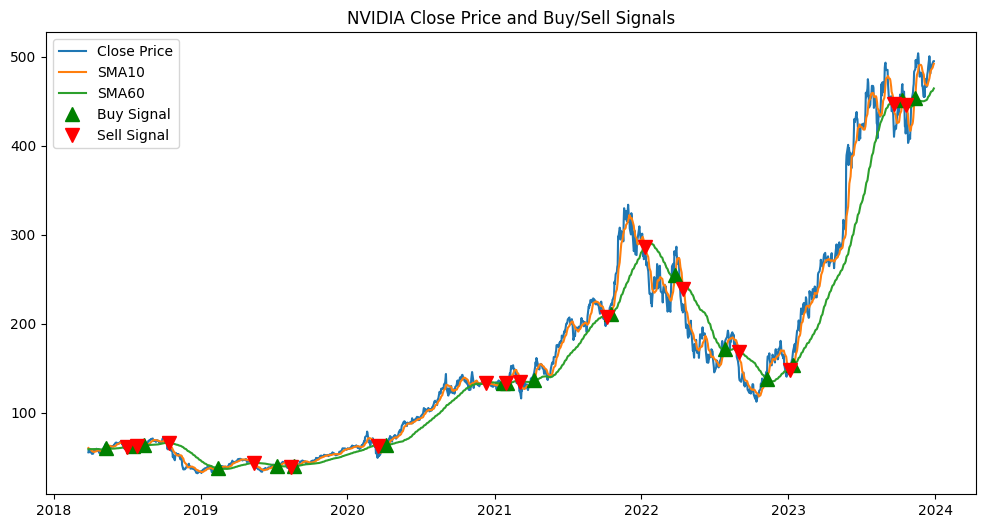

In [29]:
# Generate signals
nvidia['signal'] = 0
nvidia['signal'][10:] = np.where(nvidia['SMA10'][10:] > nvidia['SMA60'][10:], 1, 0)
nvidia['positions'] = nvidia['signal'].diff()

# Visualize signals
plt.figure(figsize=(12, 6))
plt.plot(nvidia['Close'], label='Close Price')
plt.plot(nvidia['SMA10'], label='SMA10')
plt.plot(nvidia['SMA60'], label='SMA60')
plt.plot(nvidia[nvidia['positions'] == 1].index, nvidia['SMA10'][nvidia['positions'] == 1], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(nvidia[nvidia['positions'] == -1].index, nvidia['SMA10'][nvidia['positions'] == -1], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('NVIDIA Close Price and Buy/Sell Signals')
plt.legend()
plt.show()


In [30]:
# Split the data into training and testing sets
train_size = int(len(nvidia) * 0.8)
train_df = nvidia[:train_size]
test_df = nvidia[train_size:]

# Features and target variable
X_train = train_df[['SMA10', 'SMA60', 'EMA10', 'Momentum', 'RSI']]
y_train = train_df['signal']
X_test = test_df[['SMA10', 'SMA60', 'EMA10', 'Momentum', 'RSI']]
y_test = test_df['signal']


In [31]:
# Train RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=25)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Train XGBClassifier
xgb_model = XGBClassifier(n_estimators=25, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Add predictions to the test dataframe
test_df['rf_signal'] = rf_predictions
test_df['xgb_signal'] = xgb_predictions


C:\Users\Me\AppData\Local\Temp\ipykernel_8712\1295686822.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Me\AppData\Local\Temp\ipykernel_8712\1295686822.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



RandomForest Sharpe Ratio: 2.59
RandomForest Annualized Sharpe Ratio: 2.59
XGBoost Sharpe Ratio: 2.24
XGBoost Annualized Sharpe Ratio: 2.24


C:\Users\Me\AppData\Local\Temp\ipykernel_8712\185020049.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Me\AppData\Local\Temp\ipykernel_8712\185020049.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Me\AppData\Local\Temp\ipykernel_8712\185020049.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

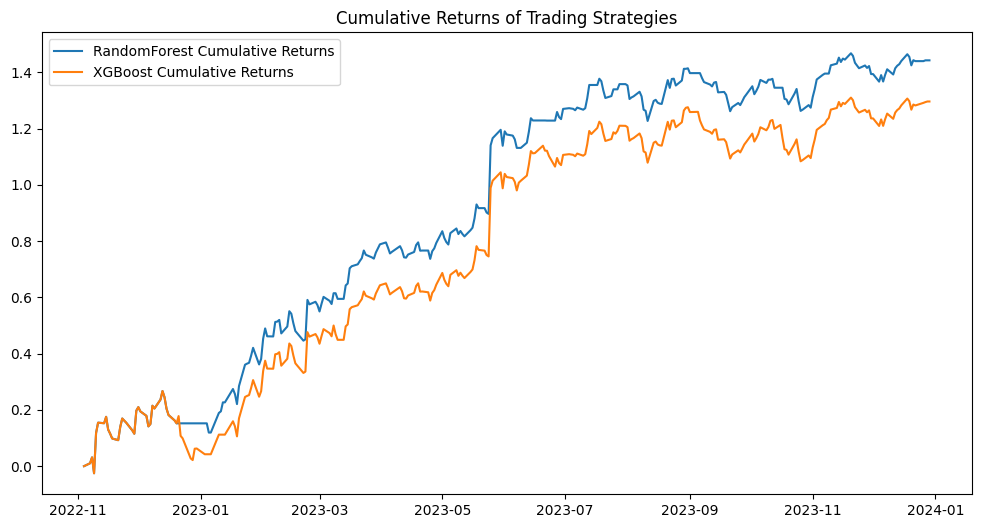

In [32]:
# Function to calculate returns and Sharpe ratio
def calculate_performance(df, signal_col):
    df['returns'] = df['Close'].pct_change()
    df['strategy_returns'] = df[signal_col].shift(1) * df['returns']
    cumulative_returns = df['strategy_returns'].cumsum()

    sharpe_ratio = (df['strategy_returns'].mean() / df['strategy_returns'].std()) * np.sqrt(252)

    annualized_return = df['strategy_returns'].mean() * 252
    annualized_volatility = df['strategy_returns'].std() * np.sqrt(252)
    annualized_sharpe_ratio = annualized_return / annualized_volatility

    return cumulative_returns, sharpe_ratio, annualized_sharpe_ratio

# Calculate performance for RandomForest strategy
rf_cumulative_returns, rf_sharpe_ratio, rf_annualized_sharpe_ratio = calculate_performance(test_df, 'rf_signal')

# Calculate performance for XGBoost strategy
xgb_cumulative_returns, xgb_sharpe_ratio, xgb_annualized_sharpe_ratio = calculate_performance(test_df, 'xgb_signal')

# Print performance metrics
print(f"RandomForest Sharpe Ratio: {rf_sharpe_ratio:.2f}")
print(f"RandomForest Annualized Sharpe Ratio: {rf_annualized_sharpe_ratio:.2f}")
print(f"XGBoost Sharpe Ratio: {xgb_sharpe_ratio:.2f}")
print(f"XGBoost Annualized Sharpe Ratio: {xgb_annualized_sharpe_ratio:.2f}")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(rf_cumulative_returns, label='RandomForest Cumulative Returns')
plt.plot(xgb_cumulative_returns, label='XGBoost Cumulative Returns')
plt.title('Cumulative Returns of Trading Strategies')
plt.legend()
plt.show()
